In [12]:
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
import pandas as pd
from astropy.constants import G
import astropy.units as u
import os
import h5py
from glob import glob
import numpy as np
import matplotlib as mpl

mpl.rc_file('/Users/alexanderescamilla/cassi/Mike_rc_params')



In [36]:
def read_yso_data(file_path):
    """
    Read YSO coordinates from the given file.
    If the file does not contain a "Masses" dataset, default to an array of zeros.
    """
    with h5py.File(file_path, "r") as f:
        YSO_X = f["X_pc"][:]
        YSO_Y = f["Y_pc"][:]
        YSO_Age = f["StarAge"][:]
        if "Masses" in f:
            YSO_Mass = f["Masses"][:]
        else:
            # Use zeros if no mass data is available
            YSO_Mass = np.zeros(len(YSO_X))
    return YSO_X, YSO_Y, YSO_Mass, YSO_Age

def read_dust_data(file_path):
    """
    Read dust coordinates and surface density from file,
    flatten the density array, and attach units.
    """
    with h5py.File(file_path, "r") as f:
        X = f["X_pc"][:]
        Y = f["Y_pc"][:]
        Surface_Den = f["SurfaceDensity_Msun_pc2"][:]
    new_den = Surface_Den.flatten() * (u.solMass / u.pc**2)
    dust_coords = np.c_[X.flatten(), Y.flatten()]
    return X, Y, Surface_Den, new_den, dust_coords

def build_dataframe(YSO_X, YSO_Y, YSO_Mass, YSO_Age, new_den, dust_coords):
    """
    Use a KDTree to map each YSO coordinate to the nearest dust cell.
    Return a DataFrame with the YSO's X, Y positions, their corresponding dust
    surface density, and their masses.
    """
    targets = np.c_[YSO_X.flatten(), YSO_Y.flatten()]
    tree = KDTree(dust_coords)
    _, idx = tree.query(targets)
    df = pd.DataFrame({
        "YSO_X": targets[:, 0],
        "YSO_Y": targets[:, 1],
        "YSO Surface Den": new_den[idx],
        "YSO Mass": YSO_Mass,
        "YSO Age": YSO_Age
    })
    return df

def compute_sfe(df, new_den, Box_Size, R_I, R_F, RES, Use_stellar_age = None):
    """
    Loop over density cutoff values and compute SFE (star formation efficiency)
    and related data.
    """
    results_list = []
    # Convert gravitational constant to proper units: pc^3/(Msun * Myr^2)
    new_G = G.to(u.pc**3 / (u.solMass * u.Myr**2)).value
    # Define a unit for surface density
    surface_unit = 1 * (u.solMass / u.pc**2)
    # Characteristic length from the simulation box
    L = Box_Size / 5

    # Use DataFrame columns for convenience
    yso_surface_den = df["YSO Surface Den"]
    yso_mass = df["YSO Mass"]
    yso_ages = df["YSO Age"]

    # Loop through the density thresholds
    for i in np.arange(R_I, R_F, 1):
        threshold = i * surface_unit
        num_yso = (yso_surface_den > threshold).sum()
        
        # StarRate using a fixed constant mass (0.5 Msun assumed)
        if Use_stellar_age == True:
            StarRate = np.sum(yso_mass / yso_ages)
        else:
            StarRate = (((num_yso * 0.5) / 0.5) * (u.solMass / u.Myr))
        
        # Compute alternative SFR using average YSO mass above threshold
        if num_yso > 0:
            avg_mass = np.mean(yso_mass[yso_surface_den > threshold])
        else:
            avg_mass = 0
        no_assumption_SFR = (((num_yso * avg_mass) / 0.5) * (u.solMass / u.Myr))
        
        # Compute additional YSO mass statistics
        if num_yso > 0:
            mean_mass = np.mean(yso_mass[yso_surface_den > threshold])
            tot_mass = np.sum(yso_mass[yso_surface_den > threshold])
            med_mass = np.median(yso_mass[yso_surface_den > threshold])
        else:
            mean_mass = np.nan
            tot_mass = np.nan
            med_mass = np.nan

        # Compute gas mass and area from the dust data using a mask
        Mask = new_den > (i * surface_unit)
        A_i = (L / RES)**2 * u.pc**2  # area per grid cell
        A = (np.sum(Mask) * A_i).value
        M_Gas = np.sum(A_i * new_den[Mask]).value

        # Compute free-fall time and efficiencies if possible
        if M_Gas <= 0 or A <= 0:
            T_ff = np.nan
            sfe = np.nan
            sfe_diff = np.nan
        else:
            t_ff_num = (A ** (3/2)) * np.sqrt(np.pi)
            t_ff_denom = 8 * new_G * M_Gas
            T_ff = np.sqrt(t_ff_num / t_ff_denom)
            if Use_stellar_age == True:
                sfe = (StarRate / (M_Gas / T_ff))
                sfe_diff = (no_assumption_SFR / (M_Gas / T_ff))
            else:
                sfe = (StarRate / (M_Gas / T_ff)).value
                sfe_diff = (no_assumption_SFR / (M_Gas / T_ff)).value

        results_list.append({
            "threshold": i,
            "SFE": sfe,
            "SFE_diff": sfe_diff,
            "N_YSOs": num_yso,
            "M_Gas": M_Gas,
            "Area": A,
            "T_ff": T_ff,
            "mean_mass": mean_mass,
            "total_mass": tot_mass,
            "median_mass": med_mass
        })
    results_df = pd.DataFrame(results_list)
    return results_df

def write_output(file1, OUTPATH, results_df):
    """
    Write the computed SFE values and associated metrics to an HDF5 file.
    """ 
    fname = os.path.basename(file1).replace(".YSOobjects.hdf5", ".e_ff_range.hdf5")
    if OUTPATH:
        outdir = OUTPATH
    else:
        outdir = os.path.join(str(pathlib.Path(file1).parent.resolve()), "E_FF")
    if not isdir(outdir):
        mkdir(outdir)
    imgpath = os.path.join(outdir, fname)

    with h5py.File(imgpath, "w") as F:
        F.create_dataset("SFE_Values", data=results_df["SFE"].to_numpy())
        F.create_dataset("SFE_Values_Different_Masses", data=results_df["SFE_diff"].to_numpy())
        F.create_dataset("NYSOs", data=results_df["N_YSOs"].to_numpy())
        F.create_dataset("M_Gas", data=results_df["M_Gas"].to_numpy())
        F.create_dataset("Area", data=results_df["Area"].to_numpy())
        F.create_dataset("T_ff", data=results_df["T_ff"].to_numpy())
        F.create_dataset("Average_YSO_Mass", data=results_df["mean_mass"].to_numpy())
        F.create_dataset("M_total", data=results_df["total_mass"].to_numpy())
        F.create_dataset("M_median", data=results_df["median_mass"].to_numpy())
    print("Output written to:", imgpath)

def SFE_values(file1, file2, Box_Size, R_I, R_F, OUTPATH, RES, return_results=False, stellar_age = False):
    """
    Pipeline: read input files, build a DataFrame, compute SFE values,
    then either write the output to a file or return the results.
    """
    # Read YSO and dust data from the input files
    YSO_X, YSO_Y, YSO_Mass, YSO_Age = read_yso_data(file1)
    X, Y, Surface_Den, new_den, dust_coords = read_dust_data(file2)
    
    # Build a DataFrame mapping each YSO to the nearest dust cell
    df = build_dataframe(YSO_X, YSO_Y, YSO_Mass,YSO_Age, new_den, dust_coords)
    
    # Compute SFE values
    if stellar_age == True:
        results_df = compute_sfe(df, new_den, Box_Size, R_I, R_F, RES, Use_stellar_age = True)
    else:
        results_df = compute_sfe(df, new_den, Box_Size, R_I, R_F, RES, Use_stellar_age = False)

    if return_results:
        return results_df
    else:
        write_output(file1, OUTPATH, results_df)


In [44]:


# Update these file paths with your own HDF5 files
file1 = glob("../snaps/YSOobjects/" + '/*.hdf5')   # YSO file
file2 = ("../snaps/snapshot_2000.dustemission.hdf5")      # Dust file
file2_YSO = "/Users/alexanderescamilla/cassi/data/snaps/YSOobjects/snapshot_3000.YSOobjects.hdf5"
file2_dust = "/Users/alexanderescamilla/cassi/data/snaps/test_high_dustemission/snapshot_3000.dustemission.hdf5"
# Simulation parameters
Box_Size = 100      # e.g., simulation box size
R_I = 65            # Starting density cutoff
R_F = 2500         # Ending density cutoff
RES = 1024          # Simulation resolution
OUTPATH = None      # Set to a directory string if needed, otherwise uses default

# Run the pipeline and return the results DataFrame
results_df = SFE_values(file1[0], file2, Box_Size, R_I, R_F, OUTPATH, RES, return_results=True)
results_df2 = SFE_values(file2_YSO, file2_dust, Box_Size, R_I, R_F, OUTPATH, RES, return_results=True)

age_results_df = SFE_values(file1[0], file2, Box_Size, R_I, R_F, OUTPATH, RES, return_results=True, stellar_age=True)

# Display first few rows of the results DataFrame
results_df.head()


KeyError: "Unable to open object (object 'StarAge' doesn't exist)"

In [37]:
age_results_df = SFE_values(file1[0], file2, Box_Size, R_I, R_F, OUTPATH, RES, return_results=True, stellar_age=True)

In [39]:
age_results_df.head()

,threshold,SFE,SFE_diff,N_YSOs,M_Gas,Area,T_ff,mean_mass,total_mass,median_mass
0,65,1.837e-03,0.017019724064623876 solMass / Myr,144,1.160e+04,8.452e+01,1.816e+00,3.777e-01,5.438e+01,2.026e-01
1,66,1.835e-03,0.017006864630696675 solMass / Myr,144,1.150e+04,8.286e+01,1.798e+00,3.777e-01,5.438e+01,2.026e-01
2,67,1.834e-03,0.016995077534953437 solMass / Myr,144,1.139e+04,8.122e+01,1.779e+00,3.777e-01,5.438e+01,2.026e-01
3,68,1.833e-03,0.016984509930886665 solMass / Myr,144,1.128e+04,7.964e+01,1.762e+00,3.777e-01,5.438e+01,2.026e-01
4,69,1.832e-03,0.016975104246824375 solMass / Myr,144,1.117e+04,7.809e+01,1.744e+00,3.777e-01,5.438e+01,2.026e-01


In [12]:
accretion_SFE = "/Users/alexanderescamilla/cassi/data/snaps/YSOobjects/E_FF/snapshot_3000.e_ff_inst_accretion.hdf5"

with h5py.File(accretion_SFE) as A:
    values = A["SFE_Acc"][:]  
    threshold = A["threshold"][:]

findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: La

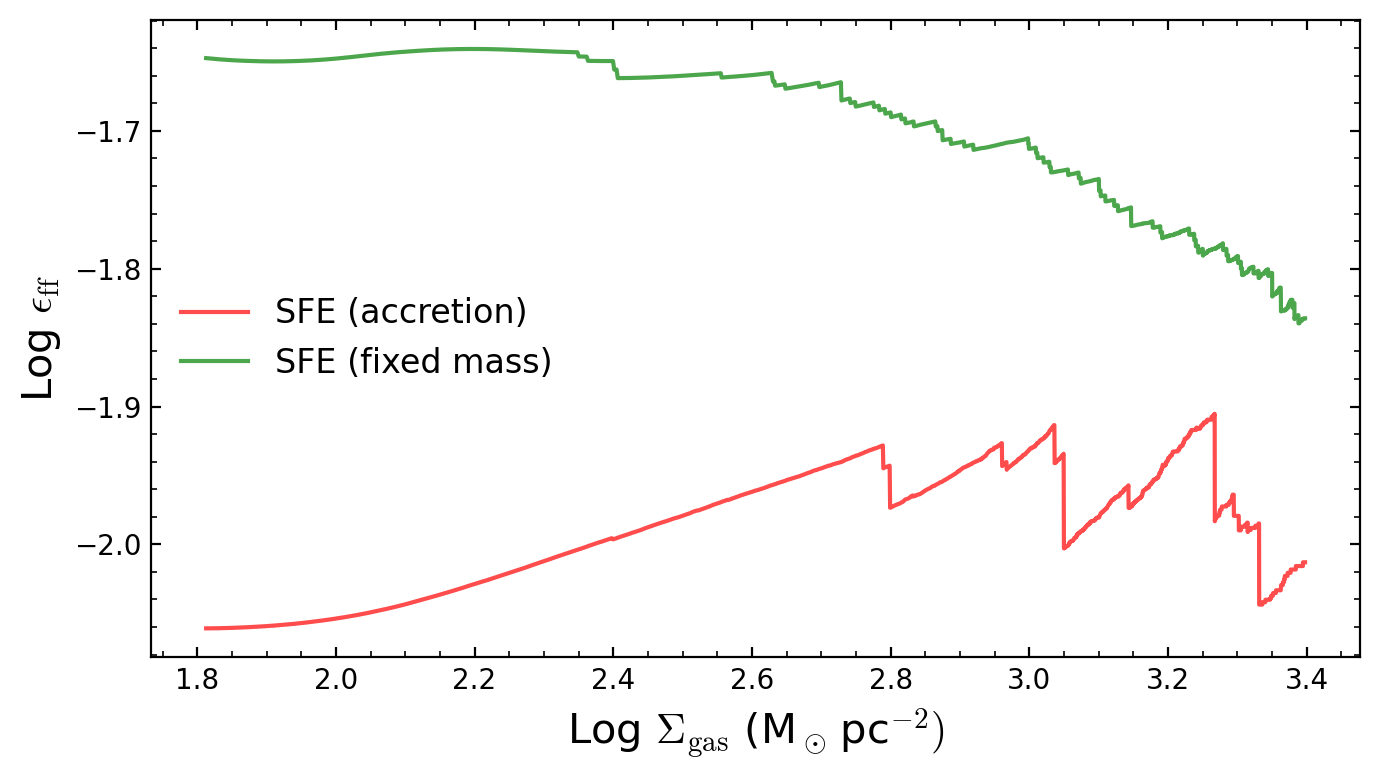

In [13]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(
    np.log10(results_df['threshold']),
    np.log10(values),
    label='SFE (accretion)',
    c='red',
    alpha=0.7,
    linestyle='-'
)
ax.plot(
    np.log10(results_df['threshold']),
    np.log10(results_df['SFE']),
    label='SFE (fixed mass)',
    c='green',
    alpha=0.7,
    linestyle='-'
)
ax.set_xlabel(r"Log $\Sigma_{\rm gas}$ (M$_\odot\,$pc$^{-2})$", fontsize=15)
ax.set_ylabel(r"Log $\epsilon_{\rm ff}$", fontsize=15)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()


In [25]:
import h5py
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from astropy.constants import G, M_sun
import astropy.units as u

snapshot_h5 = "/Users/alexanderescamilla/cassi/data/snaps/snapshot_2000.hdf5"
acc_hist_h5 = "/Users/alexanderescamilla/cassi/data/snaps/accretion_histories/accretion_histories.hdf5"
snapshot_mock_ob = "/Users/alexanderescamilla/cassi/data/snaps/snapshot_2000.dustemission.hdf5"

# Cell 2: Precompute G in pc³/(M_sun·Myr²)
G_pc = G.to(u.pc**3/(M_sun * u.Myr**2)).value

# Cell 3: Load snapshot data
with h5py.File(snapshot_h5, "r") as F:
    t_code   = F["Header"].attrs["Time"]
    t_snap   = float(t_code * 978.5)           # Myr
    gas_pos  = F["PartType0/Coordinates"][:]  # (Ngas,3) in pc
    gas_mass = F["PartType0/Masses"][:]       # (Ngas,) in M_sun
    gas_rho  = F["PartType0/Density"][:]      # (Ngas,) in M_sun/pc^3
    star_pos = F["PartType5/Coordinates"][:]  # (Nstar,3)
    star_ids = F["PartType5/ParticleIDs"][:]
    star_age = F["PartType5/ProtoStellarAge"][:] * 978.5  # (Nstar,)
    star_masses = F["PartType5/Masses"][:]

# Cell 4: Compute per-gas free-fall time and map stars → local ρ
  # (Ngas,) Myr
tree   = cKDTree(gas_pos[:, :2])
_, idx = tree.query(star_pos[:, :2])
star_rho = gas_rho[idx]

# Cell 5: Load accretion rates & build star_mdot
def load_accretion_rates(acc_file, t_snap):
    rates = {}
    with h5py.File(acc_file, "r") as f_acc:
        for grp in f_acc:
            if not grp.startswith("Star"):
                continue
            sid   = int(grp.replace("Star",""))
            t_arr = f_acc[grp]["Time_Myr"][:]     # Myr
            m_arr = f_acc[grp]["Mass_Msun"][:]    # M_sun
            j     = np.argmin(np.abs(t_arr - t_snap))
            if j > 0:
                rate = (m_arr[j] - m_arr[j-1])/(t_arr[j] - t_arr[j-1])
            elif len(m_arr) > 1:
                rate = (m_arr[1] - m_arr[0])/(t_arr[1] - t_arr[0])
            else:
                rate = 0.0
            rates[sid] = float(rate)
    return rates

acc_rates = load_accretion_rates(acc_hist_h5, t_snap)
star_mdot = np.array([acc_rates.get(int(s), 0.0) for s in star_ids])

# Cell 6: Build surface-density map (M_sun/pc^2)

def read_dust_data(file_path):
    """
    Read dust coordinates and surface density from file,
    flatten the density array, and attach units.
    """
    with h5py.File(file_path, "r") as f:
        X = f["X_pc"][:]
        Y = f["Y_pc"][:]
        Surface_Den = f["SurfaceDensity_Msun_pc2"][:]
    new_den = Surface_Den.flatten() * (u.solMass / u.pc**2)
    dust_coords = np.c_[X.flatten(), Y.flatten()]
    return X, Y, Surface_Den, new_den, dust_coords

_, _, Surface_den, flattened_surface, gas_xy = read_dust_data(snapshot_mock_ob)

tree = cKDTree(gas_xy)
star_targets =  star_pos[:,:2]
gas_targets = gas_pos[:,:2]


_, idx_stars = tree.query(star_targets)
_, idx_gas = tree.query(gas_targets)

Star_Surface_Den = (flattened_surface[idx_stars]).value

Gas_Surface_Den =  (flattened_surface[idx_gas]).value

# Cell 8: Loop over Σ thresholds 65–2500 with step=1
thresholds = np.arange(65, 2500, 1)  # 65, 66, …, 2500
rows = []
for thr in thresholds:
    mask_s   = Star_Surface_Den > thr
    Mdot_tot = star_mdot[mask_s].sum()                    # M_sun/Myr
    mask_g   = Gas_Surface_Den > thr
    gas_term = (gas_mass[mask_g] / t_ff_g[mask_g]).sum()   # M_sun/Myr
    eps_ff   = Mdot_tot / gas_term if gas_term > 0 else np.nan
    eps_ff_ages = np.sum(star_masses / star_age) / gas_term if gas_term > 0 else np.nan

    rows.append({
        "Sigma_threshold":     thr,
        "Mdot_tot_Msun_per_Myr": Mdot_tot,
        "sum_Mgas_over_tff":      gas_term,
        "epsilon_true":           eps_ff,
        "epsilon_true_ages":      eps_ff_ages
    })

results_df_real = pd.DataFrame(rows)

# Cell 9: Display results
pd.set_option('display.float_format', '{:.3e}'.format)
results_df_real.head()


,Sigma_threshold,Mdot_tot_Msun_per_Myr,sum_Mgas_over_tff,epsilon_true,epsilon_true_ages
0,65,1.757e+02,2.277e+04,7.718e-03,3.196e-03
1,66,1.757e+02,2.273e+04,7.731e-03,3.201e-03
2,67,1.757e+02,2.269e+04,7.744e-03,3.206e-03
3,68,1.757e+02,2.265e+04,7.757e-03,3.212e-03
4,69,1.757e+02,2.261e+04,7.770e-03,3.217e-03


In [41]:
eff_accretion_over_obs = (results_df_real["Mdot_tot_Msun_per_Myr"]) / (results_df["M_Gas"] / results_df["T_ff"])

In [15]:
snapshot_h5 = "/Users/alexanderescamilla/cassi/data/snaps/snapshot_2000.hdf5"
acc_hist_h5 = "/Users/alexanderescamilla/cassi/data/snaps/accretion_histories/accretion_histories.hdf5"
snapshot_mock_ob = "/Users/alexanderescamilla/cassi/data/snaps/snapshot_2000.dustemission.hdf5"


def read_dust_data(file_path):
    with h5py.File(file_path, "r") as f:
        X           = f["X_pc"][:]
        Y           = f["Y_pc"][:]
        Surface_Den = f["SurfaceDensity_Msun_pc2"][:]
    new_den     = Surface_Den.flatten() * (u.solMass/u.pc**2)
    dust_coords = np.c_[X.flatten(), Y.flatten()]
    return X, Y, Surface_Den, new_den, dust_coords

def read_snapshot_data(file_path, snapshot_mock_ob):
    with h5py.File(file_path, "r") as F:
        t_code   = F["Header"].attrs["Time"]
        t_snap   = float(t_code * 978.5)           # Myr
        gas_pos  = F["PartType0/Coordinates"][:]  # (Ngas,3) in pc
        gas_mass = F["PartType0/Masses"][:]       # (Ngas,) in M_sun
        gas_rho  = F["PartType0/Density"][:]      # (Ngas,) in M_sun/pc^3
        star_pos = F["PartType5/Coordinates"][:]  # (Nstar,3)
        star_ids = F["PartType5/ParticleIDs"][:]
        star_age = F["PartType5/ProtoStellarAge"][:] * 978.5  # (Nstar,)
        star_masses = F["PartType5/Masses"][:]


    _, _, Surface_den, flattened_surface, gas_xy = read_dust_data(snapshot_mock_ob)

    tree = cKDTree(gas_xy)
    star_targets =  star_pos[:,:2]
    gas_targets = gas_pos[:,:2]


    _, idx_stars = tree.query(star_targets)
    _, idx_gas = tree.query(gas_targets)

    Star_Surface_Den = (flattened_surface[idx_stars]).value

    Gas_Surface_Den =  (flattened_surface[idx_gas]).value

    pos_list = [tuple(xyz) for xyz in gas_pos]
    df_gas = pd.DataFrame({
        "Time Snap": t_snap,
        "Gas Positions": pos_list,
        "Gas Masses": gas_mass,
        "Gas Density": gas_rho,
        "Gas Surface Density": Gas_Surface_Den
    })
    pos_list2 = [tuple(xyz) for xyz in star_pos]
    df_stars = pd.DataFrame({
        "Star Positions": pos_list2,
        "Star IDs": star_ids,
        "Star Ages": star_age,
        "Star Masses": star_masses,
        "Star Surface Density": Star_Surface_Den,
        
    })
    return df_gas, df_stars



def load_accretion_rates(acc_file, t_snap):
    """
    For each Star<ID>, compute the time-averaged accretion rate at snapshot time t_snap
    using central differences from its Mass_Msun and Time_Myr arrays.
    Returns dict {starID: mdot_at_t_snap} in M_sun/Myr.
    """
    rates = {}
    with h5py.File(acc_file, "r") as f_acc:
        for grp in f_acc:
            if not grp.startswith("Star"):
                continue
            sid   = int(grp.replace("Star",""))
            t_arr = f_acc[grp]["Time_Myr"][:]     # Myr
            m_arr = f_acc[grp]["Mass_Msun"][:]    # M_sun
            if len(m_arr) < 2:
                rate = 0.0
            elif len(m_arr) == 2:
                dt = t_arr[1] - t_arr[0]
                dm = m_arr[1] - m_arr[0]
                rate = float(dm/dt)            
            else:
                # smooth derivative at each point
                mdot_arr = np.gradient(m_arr, t_arr)
                # find nearest index to snapshot time
                idx = np.argmin(np.abs(t_arr - t_snap))
                rate = float(mdot_arr[idx])
            rates[sid] = rate
    return rates

def compute_sfe(df_gas, df_stars, Box_Size, R_I, R_F, RES, acc_rates):
    G_pc        = G.to(u.pc**3/(u.solMass*u.Myr**2)).value
    surface_unit= 1*(u.solMass/u.pc**2)
    L           = Box_Size/5

    Gas_dens_arr   = df_gas["Gas Surface Density"].to_numpy()
    Star_dens_arr = df_stars["Star Surface Density"].to_numpy()
    id_arr      = df_stars["Star IDs"].to_numpy()
    gas_mass = df_gas["Gas Masses"].to_numpy()
    t_ff_g = np.sqrt(3*np.pi/(32 * G_pc * df_gas["Gas Density"]))
    mdot_arr    = np.array([acc_rates.get(int(sid),0.0) for sid in id_arr])


    thresholds = np.arange(R_I, R_F + 1) 
    rows = []
    for thr in thresholds:
        mask_s   = Star_dens_arr > thr
        Mdot_tot = mdot_arr[mask_s].sum()                    # M_sun/Myr
        mask_g   = Gas_dens_arr > thr
        gas_term = (gas_mass[mask_g] / t_ff_g[mask_g]).sum()   # M_sun/Myr
        eps_ff   = Mdot_tot / gas_term if gas_term > 0 else np.nan
   
        rows.append({
        "Sigma_threshold":     thr,
        "Mdot_tot_Msun_per_Myr": Mdot_tot,
        "sum_Mgas_over_tff":      gas_term,
        "epsilon_true":           eps_ff
    })

    return pd.DataFrame(rows)

def SFE_values(file1, file2, file3, Box_Size, R_I, R_F, RES):
    df_gas, df_stars = read_snapshot_data(file1,file2)
    acc_rates = load_accretion_rates(file3, df_gas["Time Snap"].iloc[0])
    results_df= compute_sfe(df_gas, df_stars,
                              Box_Size, R_I, R_F, RES, acc_rates)
    return results_df
SFE_values(snapshot_h5, snapshot_mock_ob, acc_hist_h5, Box_Size=100, R_I=65, R_F=2500, RES=1024)



,Sigma_threshold,Mdot_tot_Msun_per_Myr,sum_Mgas_over_tff,epsilon_true
0,65,175.709548,22766.112464,0.007718
1,66,175.709548,22728.512013,0.007731
2,67,175.709548,22690.470297,0.007744
3,68,175.709548,22652.421624,0.007757
4,69,175.709548,22614.449497,0.007770
...,...,...,...,...
2431,2496,122.212526,5678.425735,0.021522
2432,2497,122.212526,5678.425735,0.021522
2433,2498,122.212526,5678.425735,0.021522
2434,2499,122.212526,5678.425735,0.021522


findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Latin Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: La

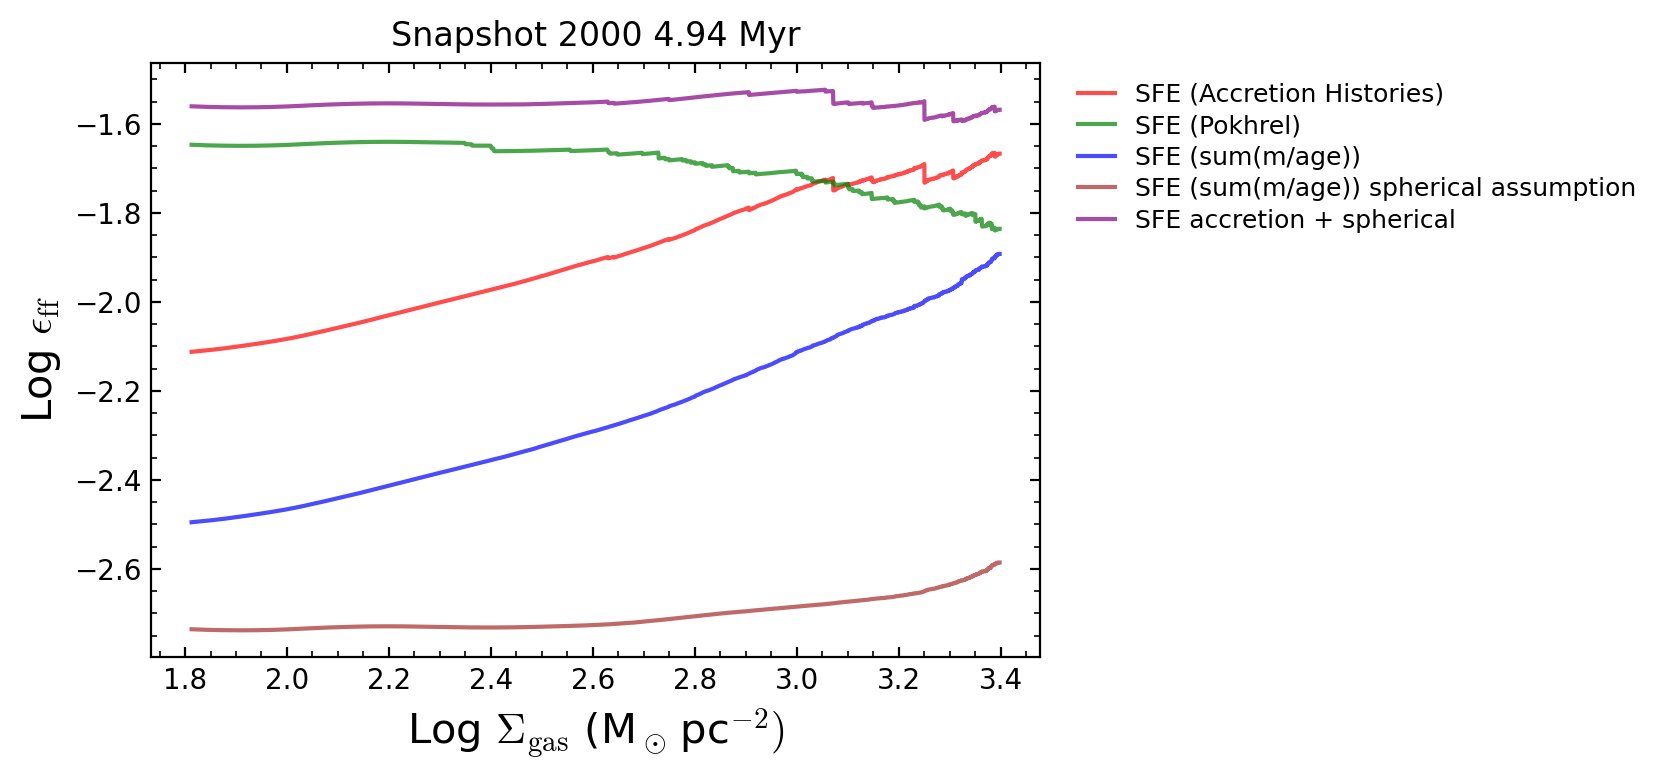

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# thresholds = np.arange(65, 2436)
# use 50 evenly spaced surface‐density cuts between 65 and 2435:
thresholds = np.linspace(65, 2500, 2435)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(
    np.log10(results_df_real["Sigma_threshold"]),
    np.log10(results_df_real["epsilon_true"]),
    label='SFE (Accretion Histories)',
    c='red', alpha=0.7, linestyle='-'
)
ax.plot(
    np.log10(results_df['threshold']),
    np.log10(results_df['SFE']),
    label='SFE (Pokhrel)',
    c='green', alpha=0.7, linestyle='-'
)
ax.plot(
    np.log10(results_df_real['Sigma_threshold']),
    np.log10(results_df_real["epsilon_true_ages"]),
    label='SFE (sum(m/age))',
    c='blue', alpha=0.7, linestyle='-'
)
ax.plot(
    np.log10(age_results_df['threshold']),
    np.log10(age_results_df["SFE"]),
    label='SFE (sum(m/age)) spherical assumption',
    c='brown', alpha=0.7, linestyle='-'
)
ax.plot(
    np.log10(age_results_df['threshold']),
    np.log10(eff_accretion_over_obs),
    label='SFE accretion + spherical',
    c='purple', alpha=0.7, linestyle='-'
)


ax.set_xlabel(r"Log $\Sigma_{\rm gas}$ (M$_\odot\,$pc$^{-2})$", fontsize=15)
ax.set_ylabel(r"Log $\epsilon_{\rm ff}$", fontsize=15)
ax.set_title(f"Snapshot 2000 {t_snap:.2f} Myr")

# move legend outside to the right
ax.legend(
    fontsize=9,
    markerscale=1,
    handlelength=1.5,
    labelspacing=0.3,
    borderpad=0.3,
    loc='upper left',
    bbox_to_anchor=(1.02, 1)       # (x, y) in axes coords. x>1 pushes it to the right.
)

# make room on the right
plt.tight_layout()
fig.subplots_adjust(right=0.75)    # reduce the right-side margin so legend isn’t cut off

plt.show()


In [ ]:
snapshots = ["/Users/alexanderescamilla/cassi/data/snaps/snapshot2000.hdf5", "/Users/alexanderescamilla/cassi/data/snaps/snapshot3000.hdf5",  ]